#Using LSTM for forcasting a Synthetic data

Outline:
1. Using a simple RNN dfor forecasting
2. Using a multi-layer LSTM for forecasting
3. Using Convolutions with LSTMs for forecasting

##Using a Simple RNN for forecasting

Here, we will use recurrent neural networks (RNNs) to build a forecasting model. In particular, we will:

* build a stacked RNN using simpleRNN layers
* use Lambda layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

We will train this on synthetic dataset

###Imports


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

###Utilities

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

###Generate the Synthetic Data


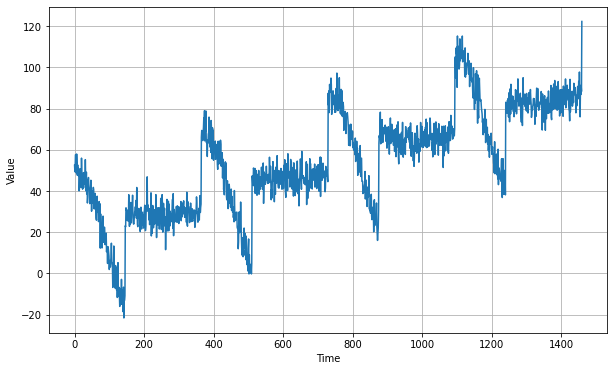

In [ ]:
from dataclasses import dataclass

def generate_time_series():
  # Parameters
  time = np.arange(4 * 365 + 1, dtype="float32")
  baseline = 10
  amplitude = 40
  slope = 0.05
  noise_level = 5

  # Create the series
  series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

  # Update with noise
  series += noise(time, noise_level, seed=42)

  return time, series

@dataclass
class G:
  time, series = generate_time_series()
  split_time = 1000
  window_size = 20
  batch_size = 32
  shuffle_buffer_size = 1000


# Plot the results
plot_series(G.time, G.series)

###Split the Dataset


In [ ]:
# Get the train set 
time_train = G.time[:G.split_time]
x_train = G.series[:G.split_time]

# Get the validation set
time_valid = G.time[G.split_time:]
x_valid = G.series[G.split_time:]

###Prepare Features and Labels

In [ ]:
def windowed_dataset(series, window_size=G.window_size, batch_size=G.batch_size, shuffle_buffer=G.shuffle_buffer_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train)

In [ ]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


###Build the Model

Our model is composed mainly of SimpleRNN layers. This type of RNN simply routs its output back to the input. You will stack two of these layers in our model so the first one should have return_sequences set to True.

As mentioned in the documentation, 
* SimpleRNN layers expect a 3-dimensional tensor input with the shape [batch, timesteps, feature]. 
* With that, we need to reshape our window from (32, 20) to (32, 20, 1). This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. 
* We can also do this within the model itself by using Lambda layers. 

Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation we need. 
* For the input_shape, we can specify None, if we want to be the model to be more flexible with the number of timesteps. 
Alternatively, we can set it to window_size as shown below if we want to set the timesteps dimension to the expected size of your data windows.

Normally, we can just a have a Dense layer output. However, we can help the training by scaling up the output to around the same figures as our labels. This will depend on the activation functions we used in your model. SimpleRNN uses tanh by default and that has an output range of [-1,1]. We will use another Lambda() layer to scale the output by 100 before it adjusts the layer weights. 


In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


###Tune the Learning Rate
We will then tune the learning rate. We will define a learning rate schedule that changes its hyperparameter dynamically. We will use the Huber Loss as our loss function to minimize sensitivity to outliers.



In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 21ms/step - loss: 75.9361 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 72.1313 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 67.3804 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 61.8898 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 55.4982 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 48.2862 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 40.6523 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 33.1985 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 27.0395 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 23.9599 - lr: 2.8184e-08
Epoch 11/100
3

We can visualize the results and pick an optimal learning rate.


(1e-08, 0.001, 0.0, 50.0)

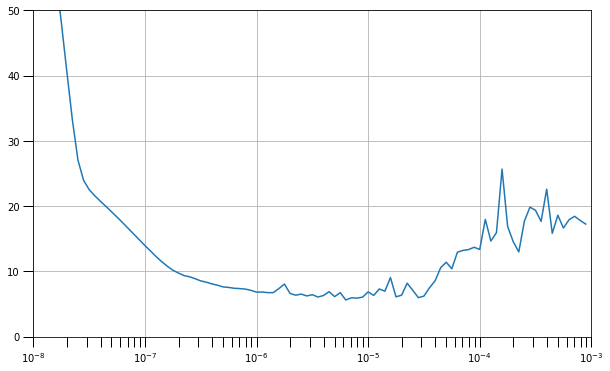

In [ ]:

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

Changing the boundaries of the graph

(1e-07, 0.0001, 0.0, 20.0)

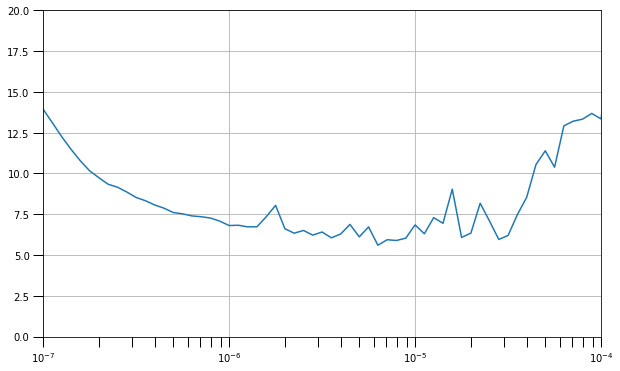

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

###Train the Model
We can then declare the model again and train with the learning rate we picked.



In [ ]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 30.9534 - mae: 31.4498
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 12.6661 - mae: 13.1530
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 10.7979 - mae: 11.2825
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 9.8618 - mae: 10.3482
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 9.0494 - mae: 9.5342
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 8.6122 - mae: 9.0915
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 8.4728 - mae: 8.9546
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 8.2659 - mae: 8.7481
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 8.1191 - mae: 8.6018
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 7.9378 - mae: 8.4193
Epoch 11/100
31/31 [========================

###Model Prediction
Now it's time to generate the model predictions for the validation set time range. The sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow.



1/1 [==============================] - 0s 27ms/step


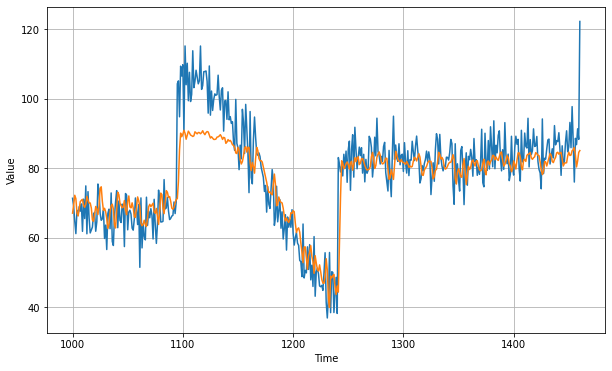

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = G.series[G.split_time - G.window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - G.window_size):
  forecast.append(model.predict(forecast_series[time:time + G.window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

We can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, we can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. We can notice that it almost mirrors the windowed_dataset() function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 9ms/step


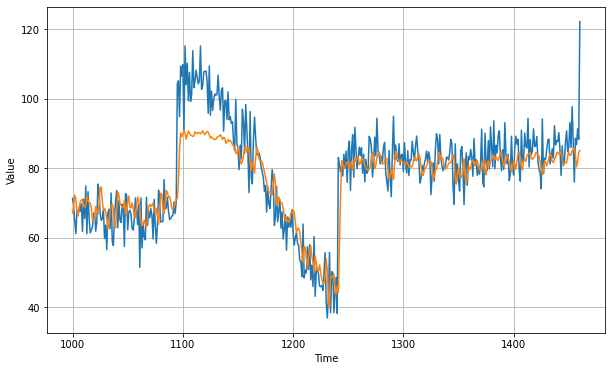

In [ ]:
# Reduce the original series
forecast_series = G.series[G.split_time - G.window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, G.window_size, G.batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

65.24971
5.9364195


##Using a multi-layer LSTM for forecasting

###Build the Model
Here we will swap SimpleRNN for LSTM. It is also set as bidirectional below. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and we'll see that when we print the model summary below.



In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

###Tune the Learning Rate
We will pick a learning rate by running the tuning code below.



In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 10s 35ms/step - loss: 62.0814 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 34ms/step - loss: 57.6984 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 50.6155 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 42.9965 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 37.9303 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 34.0577 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 34ms/step - loss: 30.5481 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 34ms/step - loss: 27.1369 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 2s 50ms/step - loss: 23.7882 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 2s 46ms/step - loss: 20.5484 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 30.0)

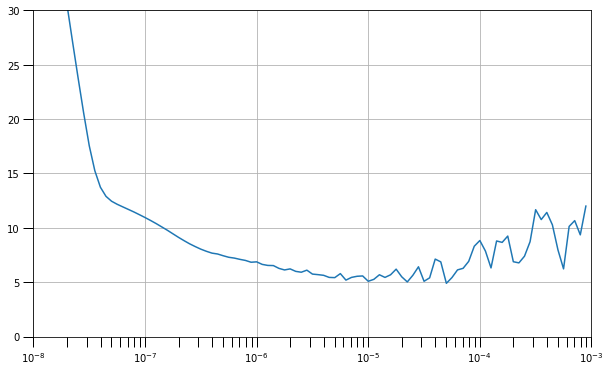

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

###Train the Model

We can then proceed to train the model with your chosen learning rate.

Tip: When experimenting and we find ourself running different iterations of a model, we may want to use the clear_session() method to declutter memory used by Keras. This is added in the first line below.



In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 9s 36ms/step - loss: 34.8212 - mae: 35.3158
Epoch 2/100
31/31 [==============================] - 1s 31ms/step - loss: 9.4802 - mae: 9.9701
Epoch 3/100
31/31 [==============================] - 1s 35ms/step - loss: 7.1606 - mae: 7.6461
Epoch 4/100
31/31 [==============================] - 1s 35ms/step - loss: 6.6714 - mae: 7.1528
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 6.2467 - mae: 6.7258
Epoch 6/100
31/31 [==============================] - 1s 35ms/step - loss: 6.0225 - mae: 6.5030
Epoch 7/100
31/31 [==============================] - 1s 34ms/step - loss: 6.1686 - mae: 6.6505
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 5.8210 - mae: 6.3018
Epoch 9/100
31/31 [==============================] - 1s 29ms/step - loss: 5.6625 - mae: 6.1436
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 5.6236 - mae: 6.1055
Epoch 11/100
31/31 [===========================

###Model Prediction
We will then generate batches of windows to generate predictions that align with the validation set.



In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


15/15 [==============================] - 2s 17ms/step


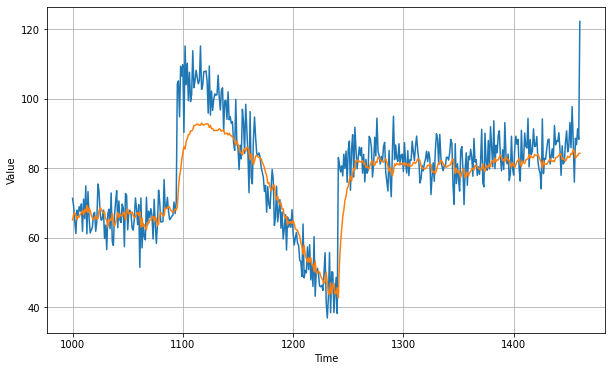

In [ ]:
# Reduce the original series
forecast_series = G.series[G.split_time-G.window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, G.window_size, G.batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


We can then generate the metrics to evaluate the model's performance.



In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

64.92489
5.788962


###Including a Validation Set while Training

First, we need to generate a val_set which are data windows and labels that our model can accept. We can simply reuse the windowed_dataset function for that and we can pass in the x_valid points to generate the windows.



In [ ]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, G.window_size, G.batch_size, G.shuffle_buffer_size)


We can then do the same training as before but pass in the val_set to the validation_data parameter of the fit() method.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 12s 115ms/step - loss: 18.0934 - mae: 18.5873 - val_loss: 22.4049 - val_mae: 22.9031
Epoch 2/100
31/31 [==============================] - 1s 40ms/step - loss: 8.3511 - mae: 8.8393 - val_loss: 8.4854 - val_mae: 8.9710
Epoch 3/100
31/31 [==============================] - 1s 41ms/step - loss: 7.3075 - mae: 7.7894 - val_loss: 7.9455 - val_mae: 8.4311
Epoch 4/100
31/31 [==============================] - 1s 38ms/step - loss: 6.3148 - mae: 6.7953 - val_loss: 8.2382 - val_mae: 8.7248
Epoch 5/100
31/31 [==============================] - 1s 39ms/step - loss: 6.0851 - mae: 6.5660 - val_loss: 7.3125 - val_mae: 7.7969
Epoch 6/100
31/31 [==============================] - 1s 35ms/step - loss: 5.7880 - mae: 6.2653 - val_loss: 8.1448 - val_mae: 8.6335
Epoch 7/100
31/31 [==============================] - 1s 41ms/step - loss: 5.3930 - mae: 5.8741 - val_loss: 7.2315 - val_mae: 7.7148
Epoch 8/100
31/31 [==============================] - 1s 41ms/step - lo

##Using Convolutions with LSTMs

###Build the Model
Here is the model architecture we will be using. It is very similar to the last RNN we built but with the Conv1D layer at the input. One important argument here is the padding. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say we have a small time series window with these values: [1, 2, 3, 4, 5]. This means the value 1 is at t=0, 2 is at t=1, etc.
* If we have a 1D kernel of size 3, then the first convolution will be for the values at [1, 2, 3] which are values for t=0 to t=2.
* When we pass this to the first timestep of the LSTM after the convolution, it means that the value at t=0 of the LSTM depends on t=1 and t=2 which are values into the future.
* For time series data, we want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: [0, 0, 1, 2, 3, 4, 5]. 1 is still at t=0 and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at [0, 0, 1] and this does not contain any future values when it is passed on to subsequent layers.

The Conv1D layer does this kind of padding by setting padding=causal and you'll see that below.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


###Tune the Learning Rate



In [ ]:
# Get initial weights
init_weights = model.get_weights()


In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 26s 119ms/step - loss: 109.8990 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 4s 127ms/step - loss: 109.4132 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 3s 97ms/step - loss: 108.8249 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 3s 94ms/step - loss: 108.1632 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 2s 67ms/step - loss: 107.4207 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 2s 60ms/step - loss: 106.5877 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 41ms/step - loss: 105.6532 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 38ms/step - loss: 104.6047 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 2s 46ms/step - loss: 103.4283 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 2s 48ms/step - loss: 102.1084 - lr: 2.8184e

(1e-08, 0.001, 0.0, 50.0)

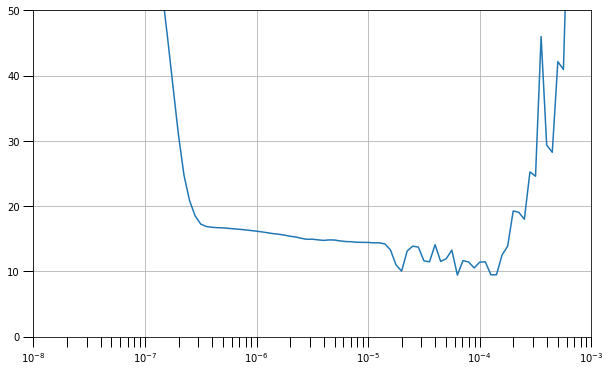

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

###Train the Model
To reset the weights, we can simply call the set_weights() and pass in the saved weights from earlier.



In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


Then we can set the training parameters and start training.


In [ ]:

# Set the learning rate
learning_rate = 5e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(dataset, epochs=350)

Epoch 1/350
31/31 [==============================] - 21s 27ms/step - loss: 38.4016 - mae: 38.9015
Epoch 2/350
31/31 [==============================] - 1s 27ms/step - loss: 29.4743 - mae: 29.9719
Epoch 3/350
31/31 [==============================] - 1s 28ms/step - loss: 11.6529 - mae: 12.1438
Epoch 4/350
31/31 [==============================] - 1s 27ms/step - loss: 10.3720 - mae: 10.8636
Epoch 5/350
31/31 [==============================] - 1s 27ms/step - loss: 13.2930 - mae: 13.7886
Epoch 6/350
31/31 [==============================] - 1s 28ms/step - loss: 10.6805 - mae: 11.1728
Epoch 7/350
31/31 [==============================] - 1s 27ms/step - loss: 7.8935 - mae: 8.3827
Epoch 8/350
31/31 [==============================] - 2s 45ms/step - loss: 8.1482 - mae: 8.6374
Epoch 9/350
31/31 [==============================] - 1s 28ms/step - loss: 8.3980 - mae: 8.8874
Epoch 10/350
31/31 [==============================] - 1s 28ms/step - loss: 6.9336 - mae: 7.4213
Epoch 11/350
31/31 [================

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


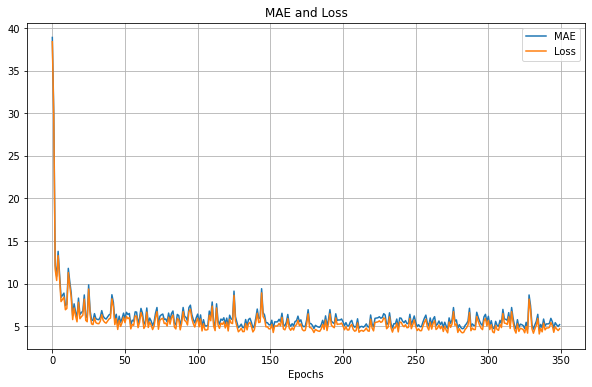

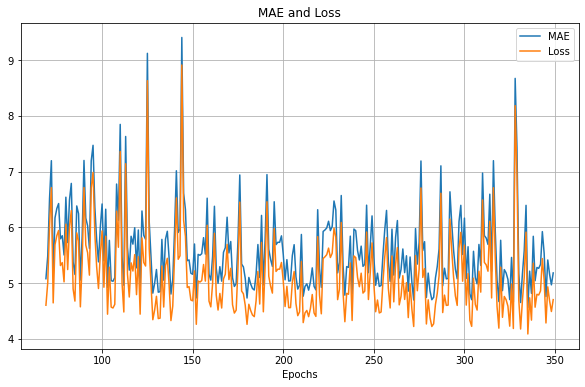

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


###Model Prediction 

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 1s 14ms/step


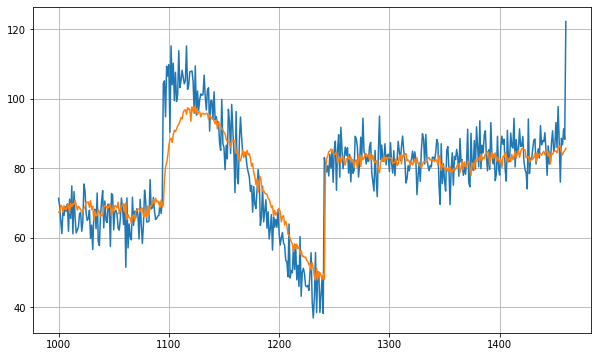

In [ ]:
# Reduce the original series
forecast_series = G.series[G.split_time-G.window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, G.window_size, G.batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

55.604794
5.4805174
